In [67]:
import json
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
import random
import numpy as np

%matplotlib inline

## Load and Clean Data

In [69]:
process_folder = '../../process'
process_config_path = '../../process/configuration/adelaide.json'
pop_col = ["pop_ghs_2015"]
dest_col = ["destinations"]
np.random.seed(24)

In [3]:
with open(process_config_path) as json_file:
    config = json.load(json_file)

input_folder = os.path.join(process_folder, config['folder'])

# the path of "adelaide_au_2020_1600m_buffer.gpkg"
gpkg_input = os.path.join(input_folder, config['geopackagePath'])

In [4]:
pop = gpd.read_file(gpkg_input, layer='pop_ghs_2015' )

In [5]:
pop.columns

Index(['index', 'pop_est', 'area_sqkm', 'pop_per_sqkm', 'intersection_count',
       'intersections_per_sqkm', 'count_pub', 'count_cafe', 'count_restaurant',
       'count_convenience', 'count_bar', 'count_fast_food', 'count_food_court',
       'count_fresh_food_market', 'count_pt_any', 'geometry'],
      dtype='object')

In [6]:
food_array = pop['count_fresh_food_market'].unique()

In [7]:
food_array

array([nan,  1.,  2.,  4.,  6.,  3.,  5.])

In [8]:
dests = gpd.read_file(gpkg_input, layer='destinations' )

In [9]:
dests.columns

Index(['dest_oid', 'osm_id', 'dest_name', 'dest_name_full', 'edge_ogc_fid',
       'n1', 'n2', 'n1_distance', 'n2_distance', 'match_point_distance',
       'geometry'],
      dtype='object')

In [10]:
dests_array = dests['dest_name_full'].unique()

In [11]:
dests_array

array(['Fresh Food / Market', 'Convenience',
       'Public transport stop (any)', 'Restaurant', 'Café', 'Food court',
       'Fast food', 'Pub', 'Bar'], dtype=object)

In [12]:
fresh_food = dests[dests['dest_name_full'].str.contains('Fresh Food / Market')]

In [13]:
gdf_study_area = gpd.read_file(gpkg_input, layer="urban_study_region")
study_area = gdf_study_area["geometry"].iloc[0]

In [14]:
crs = gdf_study_area.crs
if pop.crs != crs:
    pop = pop.to_crs(crs)
if fresh_food.crs != crs:
    fresh_food = fresh_food.to_crs(crs)

In [15]:
import warnings

warnings.filterwarnings("ignore", "GeoSeries.notna", UserWarning)  # temp warning suppression
pop_clipped = gpd.clip(pop, study_area)
fresh_food_clipped = gpd.clip(fresh_food, study_area)

## Create Density-Based Quintiles

In [16]:
pop_clipped['pop_quintile'] = pd.qcut(pop_clipped['pop_est'], 5, labels=False)

In [17]:
pop_clipped

,index,pop_est,area_sqkm,pop_per_sqkm,intersection_count,intersections_per_sqkm,count_pub,count_cafe,count_restaurant,count_convenience,count_bar,count_fast_food,count_food_court,count_fresh_food_market,count_pt_any,geometry,pop_quintile
0,40313,183.111305,0.040548,4515.914594,2,49.324258,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"POLYGON ((419652.000 -3944385.000, 419714.000 ...",4.0
2,40264,172.549214,0.040548,4255.430957,3,73.986387,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((410557.908 -3944459.000, 410600.000 ...",3.0
4,46118,365.420676,0.040548,9012.051796,11,271.283417,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((419280.000 -3939807.000, 419342.000 ...",4.0
5,46700,199.951604,0.040548,4931.232227,5,123.310644,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((423372.000 -3939371.000, 423434.000 ...",4.0
6,43320,150.517657,0.040548,3712.085837,3,73.986387,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,"POLYGON ((419466.000 -3942096.000, 419528.000 ...",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33935,73317,129.910117,0.040548,3203.860033,5,123.310644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((426906.000 -3917898.000, 426968.000 ...",2.0
33941,73526,0.603814,0.040548,14.891336,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((424483.126 -3917571.000, 424488.000 ...",0.0
33942,73527,0.286308,0.040548,7.060964,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((424488.000 -3917571.000, 424550.000 ...",0.0
33944,73760,62.798863,0.040548,1548.753643,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((426162.000 -3917462.000, 426174.703 ...",1.0


In [18]:
quintile_0 = pop_clipped.loc[pop_clipped['pop_quintile'] == 0]
quintile_1 = pop_clipped.loc[pop_clipped['pop_quintile'] == 1]
quintile_2 = pop_clipped.loc[pop_clipped['pop_quintile'] == 2]
quintile_3 = pop_clipped.loc[pop_clipped['pop_quintile'] == 3]
quintile_4 = pop_clipped.loc[pop_clipped['pop_quintile'] == 4]

## Assign Hexagon-Data to Destinations

In [19]:
joined_freshfood = gpd.sjoin(fresh_food_clipped, pop_clipped, how='right', op='within')

In [20]:
joined_freshfood.columns

Index(['index_left', 'dest_oid', 'osm_id', 'dest_name', 'dest_name_full',
       'edge_ogc_fid', 'n1', 'n2', 'n1_distance', 'n2_distance',
       'match_point_distance', 'index', 'pop_est', 'area_sqkm', 'pop_per_sqkm',
       'intersection_count', 'intersections_per_sqkm', 'count_pub',
       'count_cafe', 'count_restaurant', 'count_convenience', 'count_bar',
       'count_fast_food', 'count_food_court', 'count_fresh_food_market',
       'count_pt_any', 'geometry', 'pop_quintile'],
      dtype='object')

In [21]:
cleaned_joined_freshfood = joined_freshfood[~joined_freshfood['dest_name_full'].isnull()]

## Select Destinations

In [63]:
final_destiations = cleaned_joined_freshfood.sample(frac=1).groupby('pop_quintile', sort=False).head(10)

## Checking Work

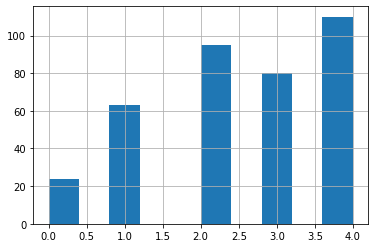

In [50]:
cleaned_joined_freshfood['pop_quintile'].hist()
plt.show()

In [ ]:
scheme = 'Quantiles'
k = 5
cmap = 'plasma'
edgecolor = 'none'
city_color = 'none'
city_edge = 'w'
city_edge_lw = 0.2
title_y = 1.02
title_fontsize = 16
title_weight = 'bold'

fontcolor = 'w'
params = {"text.color" : fontcolor,
          "ytick.color" : fontcolor,
          "xtick.color" : fontcolor}
plt.rcParams.update(params)

In [ ]:
cleaned_joined_freshfood.plot(column='n1', cmap=cmap, edgecolor=edgecolor)

In [ ]:
pop_clipped.plot(column='pop_est', cmap=cmap, edgecolor=edgecolor)

In [ ]:
pop.plot(column='pop_est', cmap=cmap, edgecolor=edgecolor)

In [ ]:
pop.head(1).plot(column='pop_est', cmap=cmap, edgecolor=edgecolor)

In [ ]:
dests.plot(column='n1', cmap=cmap, edgecolor=edgecolor)

In [ ]:
grouped_quintiles = cleaned_joined_freshfood.groupby('pop_quintile')

In [ ]:
quintile_0adelaide_au_2020_1600m_buffer.gpkg